In [1]:
!conda install -c conda-forge folium=0.5.0 --yes 
!pip install shapely

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    altair:  2.2.2-py35_1 conda-forge
    branca:  0.3.0-py_0   conda-forge
    folium:  0.5.0-py_0   conda-forge
    vincent: 0.4.4-py_1   conda-forge

altair-2.2.2-p 100% |################################| Time: 0:00:00   1.20 MB/s
branca-0.3.0-p 100% |################################| Time: 0:00:00  24.73 MB/s
vincent-0.4.4- 100% |################################| Time: 0:00:00  28.37 MB/s
folium-0.5.0-p 100% |################################| Time: 0:00:00  36.28 MB/s
    100% |████████████████████████████████| 1.5MB 555kB/s ta 0:00:01


In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json
import folium
import requests

import matplotlib.cm as cm
import matplotlib.colors as colors

## 1. Download Dataset

#### Get datasets of neighborhoods from London, San Francisco, Sydney, Amsterdam and paris from airbn data repository

In [3]:
!wget -q -O 'london_data.json' http://data.insideairbnb.com/united-kingdom/england/london/2018-08-08/visualisations/neighbourhoods.geojson
!wget -q -O 'san_francisco_data.json' http://data.insideairbnb.com/united-states/ca/san-francisco/2018-08-06/visualisations/neighbourhoods.geojson
!wget -q -O 'sydney_data.json' http://data.insideairbnb.com/australia/nsw/sydney/2018-08-08/visualisations/neighbourhoods.geojson
!wget -q -O 'amsterdam_data.json' http://data.insideairbnb.com/the-netherlands/north-holland/amsterdam/2018-08-07/visualisations/neighbourhoods.geojson
!wget -q -O 'paris_data.json' http://data.insideairbnb.com/france/ile-de-france/paris/2018-08-13/visualisations/neighbourhoods.geojson

In [4]:
cities = ['Paris', 'London', 'Sydney', 'San Francisco', 'Amsterdam']
geo_data ={}

with open('london_data.json') as json_data:
    geo_data['London'] = json.load(json_data)
    
with open('san_francisco_data.json') as json_data:
    geo_data['San Francisco'] = json.load(json_data)    
    
with open('sydney_data.json') as json_data:
    geo_data['Sydney'] = json.load(json_data)
    
with open('amsterdam_data.json') as json_data:
    geo_data['Amsterdam'] = json.load(json_data)      
    
with open('paris_data.json') as json_data:
    geo_data['Paris'] = json.load(json_data)           
    


#### Get representative latitude and longitude for each neighborhood 

In [5]:
from shapely.geometry import shape

column_names = ['City', 'Neighborhood', 'Latitude', 'Longitude'] 
neighborhoods = pd.DataFrame(columns=column_names)

for city in cities:
    for data in geo_data[city]['features']:
        neighborhood_name = data['properties']['neighbourhood']
        
        neighborhood_latlon = shape(data['geometry']).representative_point()._get_coords()[0]
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        
        neighborhoods = neighborhoods.append({'City':city,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
neighborhoods.head()

,City,Neighborhood,Latitude,Longitude
0,Paris,Batignolles-Monceau,48.887034,2.306204
1,Paris,Palais-Bourbon,48.854715,2.312969
2,Paris,Buttes-Chaumont,48.887149,2.383096
3,Paris,Opéra,48.877029,2.337891
4,Paris,Entrepôt,48.875907,2.360472


#### Test data with Paris neighborhoods

In [6]:
city = 'Paris'

df = neighborhoods[neighborhoods['City'] == city]

latitude = df.iloc[0]['Latitude']
longitude = df.iloc[0]['Longitude']

kclusters = 3
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

mapc = folium.Map(location=[latitude, longitude], zoom_start=10)


for i in range(0,len(geo_data[city]['features'])):
    folium.GeoJson(geo_data[city]['features'][i]['geometry']).add_to(mapc)

for lat, lng, city, neighborhood in zip(df['Latitude'], df['Longitude'], df['City'], df['Neighborhood']):

    label = folium.Popup(neighborhood, parse_html=True)
    
    cluster = 1
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(mapc)
    
mapc

## 2. Get venues for each neighborhood using foursquare API

In [7]:
# The code was removed by Watson Studio for sharing.

In [8]:
def getNearbyVenues(cities, names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for city, name, lat, lng in zip(cities, names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            city,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City','Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [10]:
venues = getNearbyVenues(cities=neighborhoods['City'], names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

Batignolles-Monceau
Palais-Bourbon
Buttes-Chaumont
Opéra
Entrepôt
Gobelins
Vaugirard
Reuilly
Louvre
Luxembourg
Élysée
Temple
Ménilmontant
Panthéon
Passy
Observatoire
Popincourt
Bourse
Buttes-Montmartre
Hôtel-de-Ville
Kingston upon Thames
Croydon
Bromley
Hounslow
Ealing
Havering
Hillingdon
Harrow
Brent
Barnet
Enfield
Waltham Forest
Redbridge
Sutton
Lambeth
Southwark
Lewisham
Greenwich
Bexley
Richmond upon Thames
Merton
Wandsworth
Hammersmith and Fulham
Kensington and Chelsea
City of London
Westminster
Camden
Tower Hamlets
Islington
Hackney
Haringey
Newham
Barking and Dagenham
Pittwater
Randwick
Waverley
Warringah
Lane Cove
North Sydney
Bankstown
Canterbury
Strathfield
Auburn
The Hills Shire
Hunters Hill
Sydney
Botany Bay
Hurstville
Fairfield
Blacktown
Holroyd
Ashfield
Marrickville
Sutherland Shire
Rockdale
City Of Kogarah
Parramatta
Ryde
Leichhardt
Hornsby
Ku-Ring-Gai
Willoughby
Liverpool
Penrith
Canada Bay
Camden
Campbelltown
Mosman
Manly
Woollahra
Burwood
Seacliff
Haight Ashbury
Outer

In [11]:
venues.groupby(['City', 'Neighborhood']).count()

Neighborhood Latitude  \
City          Neighborhood                                                    
Amsterdam     Bijlmer-Centrum                                            18   
              Bijlmer-Oost                                               18   
              Bos en Lommer                                              44   
              Buitenveldert - Zuidas                                     49   
              Centrum-Oost                                               48   
              Centrum-West                                              100   
              De Aker - Nieuw Sloten                                     19   
              De Baarsjes - Oud-West                                     81   
              De Pijp - Rivierenbuurt                                    38   
              Gaasperdam - Driemond                                       5   
              Geuzenveld - Slotermeer                                    10   
              IJburg - Zeeburgereiland                                    6   
              Noord-Oost                                                  1   
              Noord-West                                                  3   
              Oostelijk Havengebied - Indische Buurt                      4   
              Osdorp                                                     15   
              Oud-Noord                                                  15   
              Oud-Oost                                                   61   
              Slotervaart                                                13   
              Watergraafsmeer                                             5   
              Westerpark                                                 40   
              Zuid                                                       29   
London        Barking and Dagenham                                        5   
              Barnet                                                      4   
              Bexley                                                      9   
              Brent                                                      16   
              Bromley                                                     4   
              Camden                                                     31   
              City of London                                            100   
              Croydon                                                     3   
              Ealing                                                     22   
              Enfield                                                    49   
              Greenwich                                                   5   
              Hackney                                                    42   
              Hammersmith and Fulham                                     19   
              Haringey                                                   36   
              Harrow                                                      7   
              Havering                                                   15   
              Hillingdon                                                  5   
              Hounslow                                                   12   
              Islington                                                  68   
              Kensington and Chelsea                                     23   
              Kingston upon Thames                                       12   
              Lambeth                                                    19   
              Lewisham                                                   10   
              Merton                                                     15   
              Newham                                                      6   
              Redbridge                                                   2   
              Richmond upon Thames                                        3   
              Southwark  

In [12]:
print('There are {} uniques categories.'.format(len(venues['Venue Category'].unique())))
print('There are {} uniques neighborhoods.'.format(len(venues['Neighborhood'].unique())))

There are 386 uniques categories.
There are 142 uniques neighborhoods.


#### Select the only most common categories along neighborhoods (categories in the p% of the neighborhoods)

In [13]:
def get_common_categories(p, v):
    venue_counts = v[['Venue Category', 'Neighborhood']].drop_duplicates().groupby('Venue Category').count().reset_index()

    venue_counts = venue_counts.sort_values(['Neighborhood'], ascending=[0]).reset_index()
    venue_counts['% Neighborhoods'] = venue_counts['Neighborhood']/len(venues['Neighborhood'].unique())

    categories = venue_counts[venue_counts['% Neighborhoods'] >= p]['Venue Category']

    filtered_venues = v[v['Venue Category'].isin(categories)]
    
    return filtered_venues

filtered_venues = get_common_categories(0.0, venues)
print('There are {} uniques categories.'.format(len(filtered_venues['Venue Category'].unique())))
print('There are {} uniques neighborhoods.'.format(len(filtered_venues['Neighborhood'].unique())))

There are 386 uniques categories.
There are 142 uniques neighborhoods.


In [14]:
# one hot encoding and grouping

def group_categories(df):
    # one hot encoding
    cities_onehot = pd.get_dummies(df[['Venue Category']], prefix="", prefix_sep="")

    # add neighborhood and city columns back to dataframe
 
    cities_onehot['Neighborhood'] = filtered_venues['Neighborhood']
    cities_onehot['City'] = filtered_venues['City']

    columns = list(cities_onehot.columns)
    columns.remove('Neighborhood')
    columns.remove('City')

    fixed_columns = ['City', 'Neighborhood'] + columns
    cities_onehot = cities_onehot[list(fixed_columns)]
    
    # group counts
    cities_grouped = cities_onehot.groupby(['City', 'Neighborhood']).mean().reset_index()
    return cities_grouped

    
cities_grouped = group_categories(filtered_venues)
cities_grouped.head()

,City,Neighborhood,ATM,Acai House,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Alternative Healer,American Restaurant,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basque Restaurant,Bath House,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Bowling Green,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burgundian Restaurant,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Ch'ti Restaurant,Chaat Place,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,College Gym,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Corsican Restaurant,Cosmetics Shop,Coworking Space,Creperie,Cricket Ground,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Dive Bar,Dive Shop,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Friterie,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Hunan Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Island,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Jiangsu Restaurant,Juice Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Lyonese Bouchon,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,National Park,Nature Preserve,New American Restaurant,Newsstand,Nightclub,Noodle House,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Outlet Store,Paintball Field,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmac

In [15]:
cities_grouped.shape

(142, 387)

## 3. Analyze  Neighborhoods

In [17]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import collections
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from itertools import groupby

# set number of clusters
range_n_clusters =  list(range(2,11))

def test_clusters(p):
    filtered_venues = get_common_categories(p, venues)
    cities_grouped = group_categories(filtered_venues)

    cities_grouped_clustering = cities_grouped.drop(['City','Neighborhood'], 1)

    for n_clusters in range_n_clusters:
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(cities_grouped_clustering)

        silhouette_avg = silhouette_score(cities_grouped_clustering, cluster_labels)
        sample_silhouette_values = silhouette_samples(cities_grouped_clustering, cluster_labels)

        y_lower = 10

        fig, ax1 = plt.subplots(1)
        fig.set_size_inches(5, 4)

        ax1.set_xlim([-0.1, 1])

        ax1.set_ylim([0, len(cities_grouped_clustering) + (n_clusters + 1) * 10])


        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])    

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

        plt.show()

        for key, group in groupby(sorted(cluster_labels)):
            print("Number of items in cluster {}: {}".format(key,len(list(group))))


#### Test from 2 to 10 clusers using different values of p% for common categories along neighborhoods, in order to identify the best set of categories that give us a better distribution of clusters.

#### p=0 tests 2 to 10 clusters with all available categories. It's possible to see that this setting doesn't result on good clusters distributions, there is a cluster that always get almost all data points.

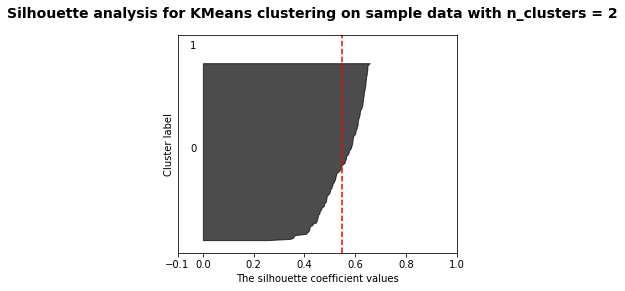

Number of items in cluster 0: 141
Number of items in cluster 1: 1


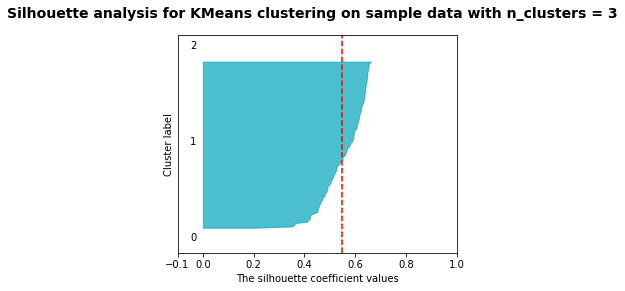

Number of items in cluster 0: 1
Number of items in cluster 1: 140
Number of items in cluster 2: 1


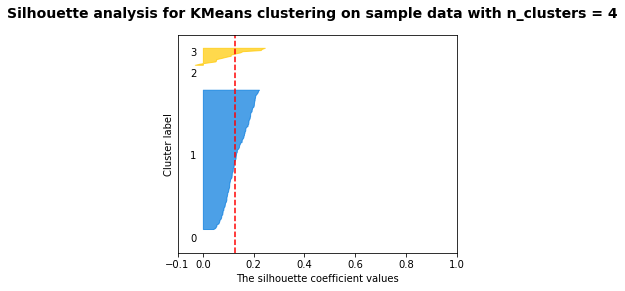

Number of items in cluster 0: 1
Number of items in cluster 1: 124
Number of items in cluster 2: 1
Number of items in cluster 3: 16


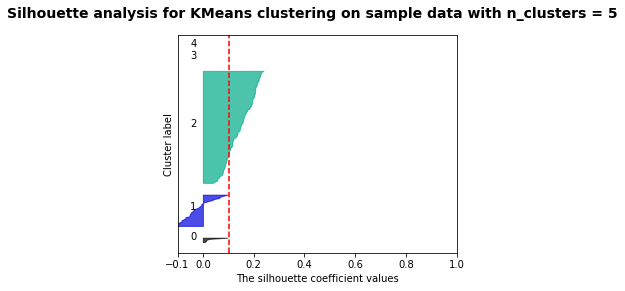

Number of items in cluster 0: 5
Number of items in cluster 1: 30
Number of items in cluster 2: 105
Number of items in cluster 3: 1
Number of items in cluster 4: 1


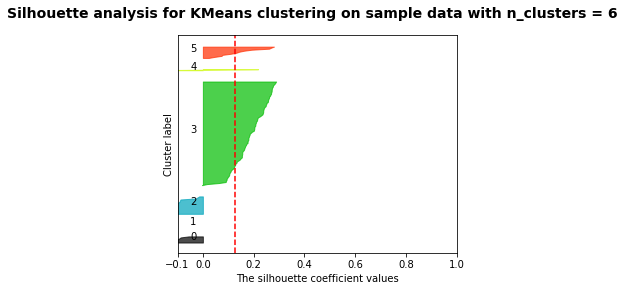

Number of items in cluster 0: 7
Number of items in cluster 1: 1
Number of items in cluster 2: 18
Number of items in cluster 3: 102
Number of items in cluster 4: 2
Number of items in cluster 5: 12


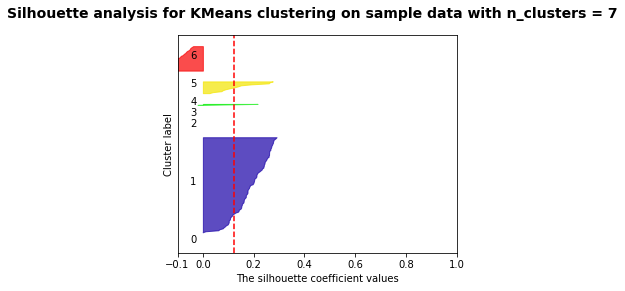

Number of items in cluster 0: 1
Number of items in cluster 1: 98
Number of items in cluster 2: 1
Number of items in cluster 3: 1
Number of items in cluster 4: 2
Number of items in cluster 5: 13
Number of items in cluster 6: 26


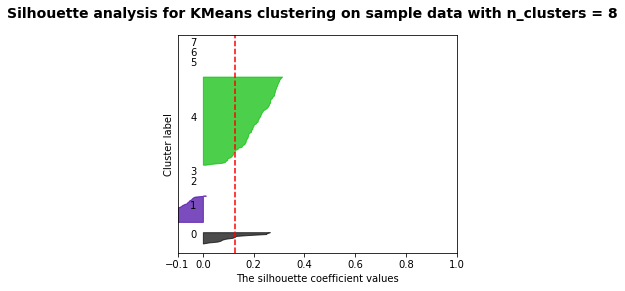

Number of items in cluster 0: 13
Number of items in cluster 1: 29
Number of items in cluster 2: 1
Number of items in cluster 3: 1
Number of items in cluster 4: 95
Number of items in cluster 5: 1
Number of items in cluster 6: 1
Number of items in cluster 7: 1


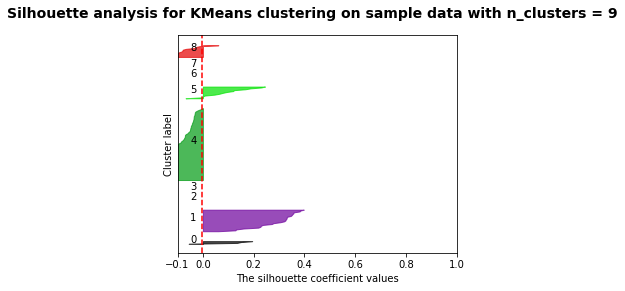

Number of items in cluster 0: 4
Number of items in cluster 1: 25
Number of items in cluster 2: 1
Number of items in cluster 3: 1
Number of items in cluster 4: 81
Number of items in cluster 5: 14
Number of items in cluster 6: 1
Number of items in cluster 7: 1
Number of items in cluster 8: 14


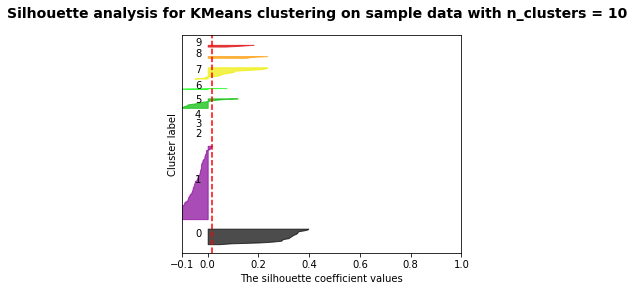

Number of items in cluster 0: 19
Number of items in cluster 1: 86
Number of items in cluster 2: 1
Number of items in cluster 3: 1
Number of items in cluster 4: 1
Number of items in cluster 5: 12
Number of items in cluster 6: 2
Number of items in cluster 7: 14
Number of items in cluster 8: 3
Number of items in cluster 9: 3


In [18]:
# Clusters with all categories
test_clusters(p=0)

#### p=0.1 tests 2 to 10 clusters with categories in at least 10% of the neigborhoods categories. It's possible to see that this setting doesn't result on good clusters distributions, there is a cluster that always get almost all data points.

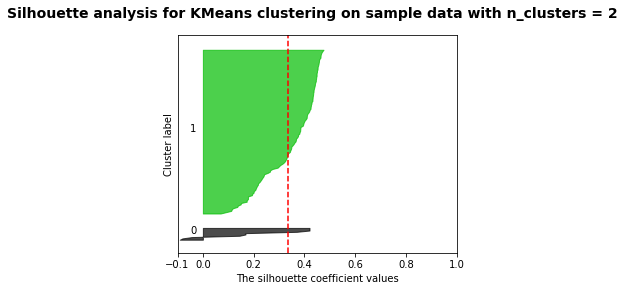

Number of items in cluster 0: 10
Number of items in cluster 1: 126


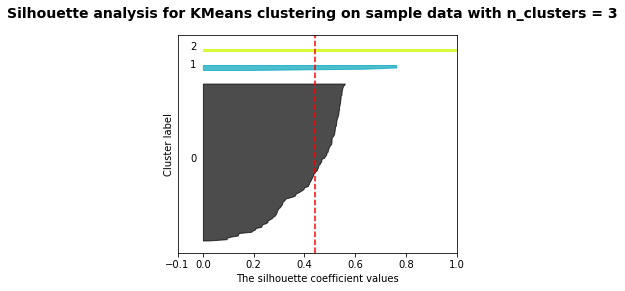

Number of items in cluster 0: 128
Number of items in cluster 1: 5
Number of items in cluster 2: 3


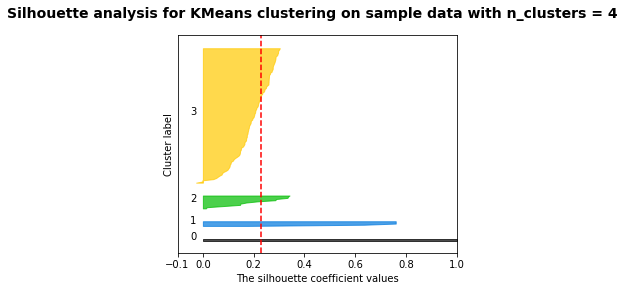

Number of items in cluster 0: 3
Number of items in cluster 1: 5
Number of items in cluster 2: 12
Number of items in cluster 3: 116


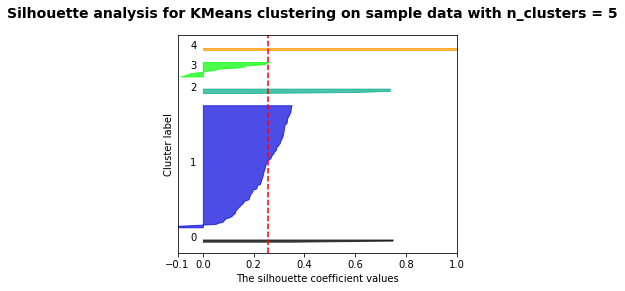

Number of items in cluster 0: 3
Number of items in cluster 1: 111
Number of items in cluster 2: 5
Number of items in cluster 3: 14
Number of items in cluster 4: 3


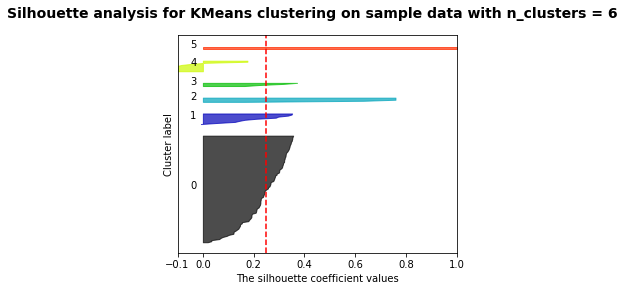

Number of items in cluster 0: 102
Number of items in cluster 1: 11
Number of items in cluster 2: 5
Number of items in cluster 3: 4
Number of items in cluster 4: 11
Number of items in cluster 5: 3


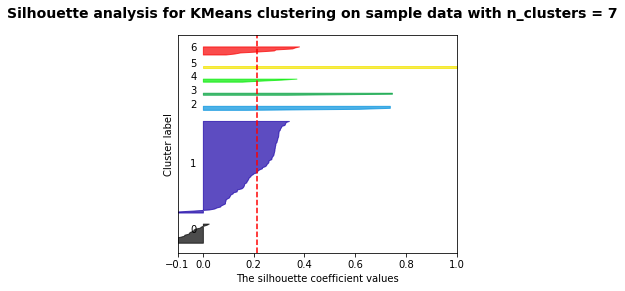

Number of items in cluster 0: 20
Number of items in cluster 1: 92
Number of items in cluster 2: 5
Number of items in cluster 3: 3
Number of items in cluster 4: 4
Number of items in cluster 5: 3
Number of items in cluster 6: 9


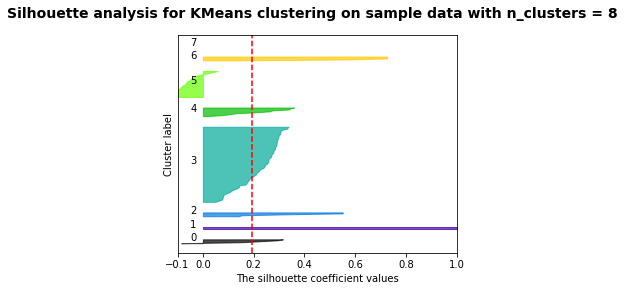

Number of items in cluster 0: 5
Number of items in cluster 1: 3
Number of items in cluster 2: 5
Number of items in cluster 3: 79
Number of items in cluster 4: 10
Number of items in cluster 5: 28
Number of items in cluster 6: 5
Number of items in cluster 7: 1


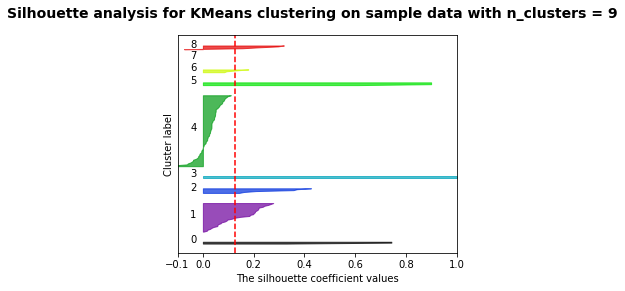

Number of items in cluster 0: 3
Number of items in cluster 1: 32
Number of items in cluster 2: 6
Number of items in cluster 3: 3
Number of items in cluster 4: 78
Number of items in cluster 5: 4
Number of items in cluster 6: 4
Number of items in cluster 7: 1
Number of items in cluster 8: 5


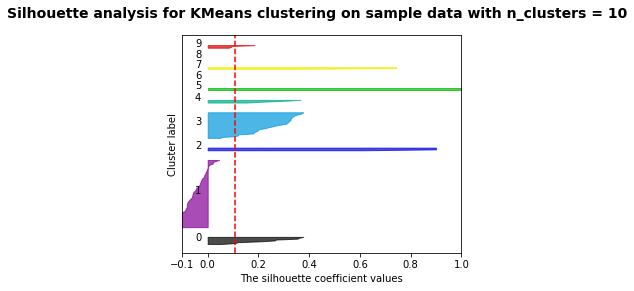

Number of items in cluster 0: 9
Number of items in cluster 1: 77
Number of items in cluster 2: 4
Number of items in cluster 3: 30
Number of items in cluster 4: 4
Number of items in cluster 5: 3
Number of items in cluster 6: 1
Number of items in cluster 7: 3
Number of items in cluster 8: 1
Number of items in cluster 9: 4


In [19]:
# Clusters with common categories in at least 10% of the neigborhoods
test_clusters(0.1)

#### p=0.2 tests 2 to 10 clusters with categories in at least 20% of the neigborhoods categories. It's possible to see that this setting improves a little bit cluster distributions with 4 clusters. Also, al clusters silhuette are avobe the mean.

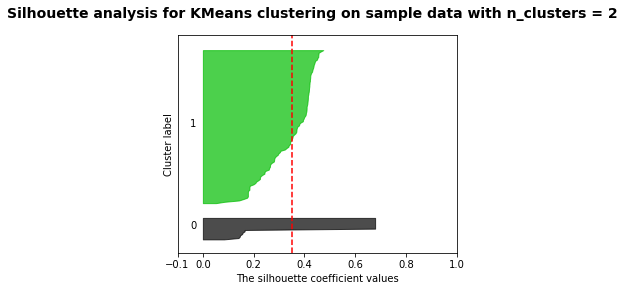

Number of items in cluster 0: 17
Number of items in cluster 1: 115


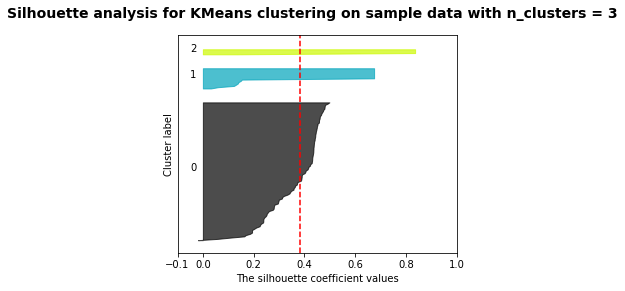

Number of items in cluster 0: 110
Number of items in cluster 1: 17
Number of items in cluster 2: 5


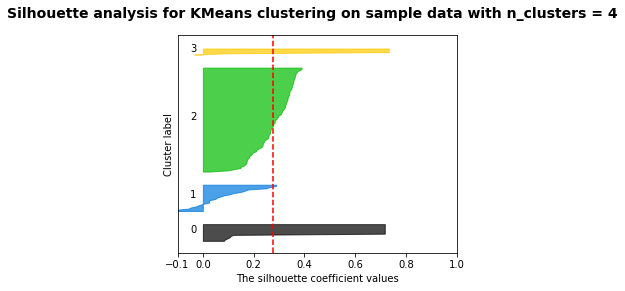

Number of items in cluster 0: 15
Number of items in cluster 1: 23
Number of items in cluster 2: 88
Number of items in cluster 3: 6


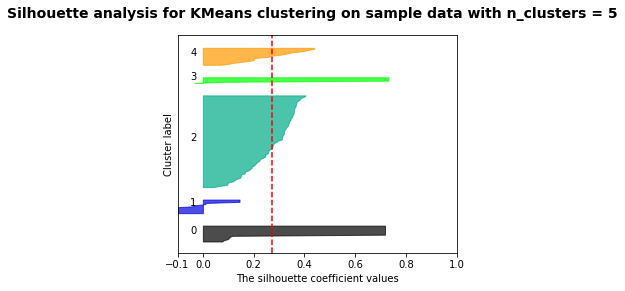

Number of items in cluster 0: 15
Number of items in cluster 1: 13
Number of items in cluster 2: 82
Number of items in cluster 3: 6
Number of items in cluster 4: 16


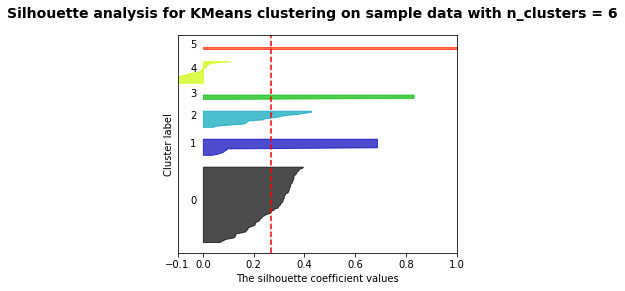

Number of items in cluster 0: 71
Number of items in cluster 1: 16
Number of items in cluster 2: 16
Number of items in cluster 3: 5
Number of items in cluster 4: 21
Number of items in cluster 5: 3


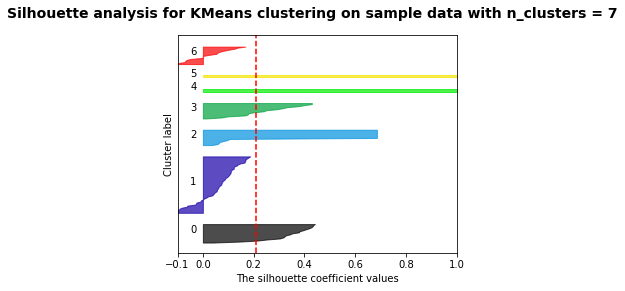

Number of items in cluster 0: 19
Number of items in cluster 1: 56
Number of items in cluster 2: 16
Number of items in cluster 3: 16
Number of items in cluster 4: 4
Number of items in cluster 5: 3
Number of items in cluster 6: 18


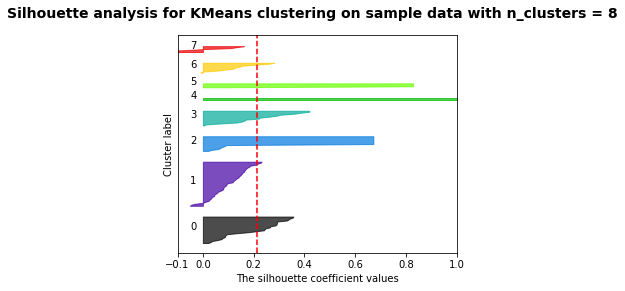

Number of items in cluster 0: 28
Number of items in cluster 1: 46
Number of items in cluster 2: 16
Number of items in cluster 3: 16
Number of items in cluster 4: 3
Number of items in cluster 5: 5
Number of items in cluster 6: 11
Number of items in cluster 7: 7


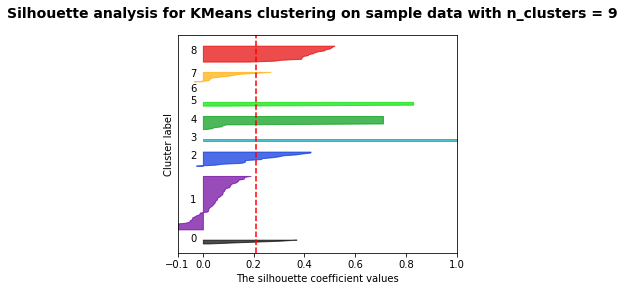

Number of items in cluster 0: 5
Number of items in cluster 1: 58
Number of items in cluster 2: 16
Number of items in cluster 3: 3
Number of items in cluster 4: 15
Number of items in cluster 5: 5
Number of items in cluster 6: 1
Number of items in cluster 7: 11
Number of items in cluster 8: 18


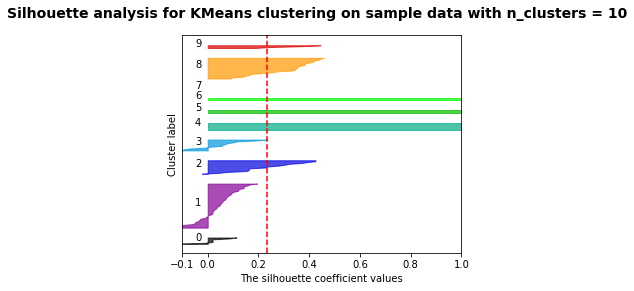

Number of items in cluster 0: 8
Number of items in cluster 1: 50
Number of items in cluster 2: 16
Number of items in cluster 3: 13
Number of items in cluster 4: 9
Number of items in cluster 5: 4
Number of items in cluster 6: 3
Number of items in cluster 7: 1
Number of items in cluster 8: 24
Number of items in cluster 9: 4


In [23]:
# Clusters with common categories in at least 20% of the neigborhoods
test_clusters(0.2)

#### p=0.3 tests 2 to 10 clusters with categories in at least 30% of the neigborhoods categories. The results are similar to p=0.2

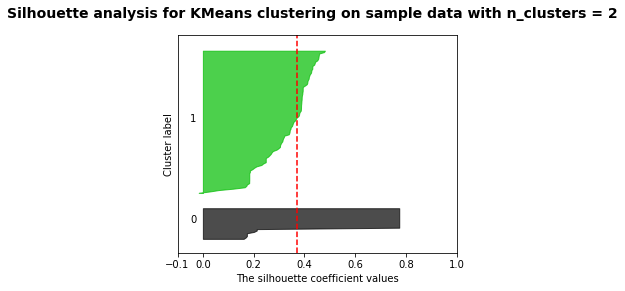

Number of items in cluster 0: 23
Number of items in cluster 1: 103


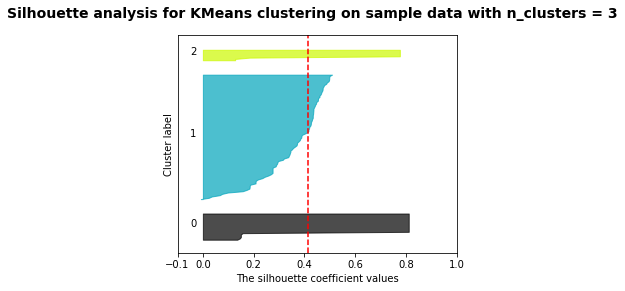

Number of items in cluster 0: 21
Number of items in cluster 1: 96
Number of items in cluster 2: 9


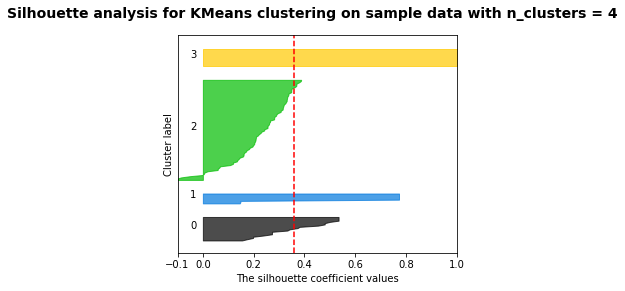

Number of items in cluster 0: 20
Number of items in cluster 1: 9
Number of items in cluster 2: 82
Number of items in cluster 3: 15


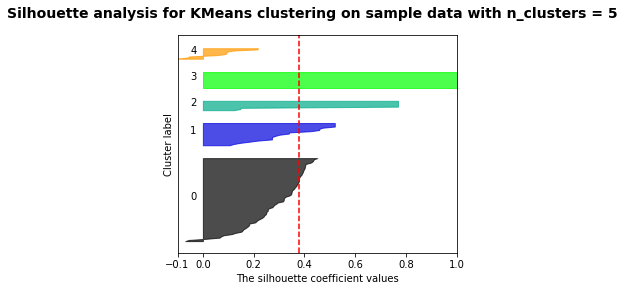

Number of items in cluster 0: 72
Number of items in cluster 1: 20
Number of items in cluster 2: 9
Number of items in cluster 3: 15
Number of items in cluster 4: 10


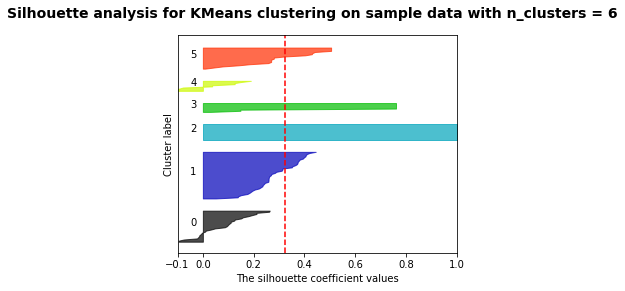

Number of items in cluster 0: 29
Number of items in cluster 1: 43
Number of items in cluster 2: 15
Number of items in cluster 3: 9
Number of items in cluster 4: 10
Number of items in cluster 5: 20


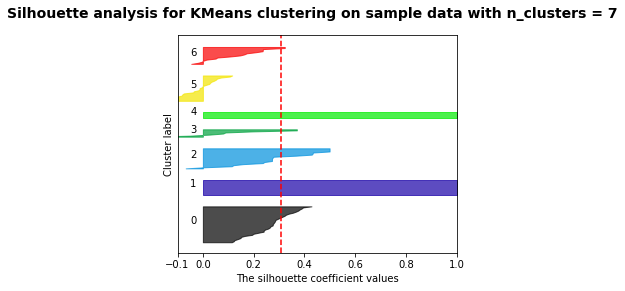

Number of items in cluster 0: 35
Number of items in cluster 1: 15
Number of items in cluster 2: 20
Number of items in cluster 3: 8
Number of items in cluster 4: 6
Number of items in cluster 5: 25
Number of items in cluster 6: 17


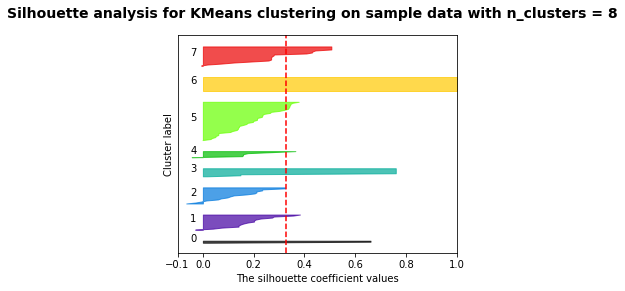

Number of items in cluster 0: 3
Number of items in cluster 1: 16
Number of items in cluster 2: 17
Number of items in cluster 3: 9
Number of items in cluster 4: 7
Number of items in cluster 5: 39
Number of items in cluster 6: 15
Number of items in cluster 7: 20


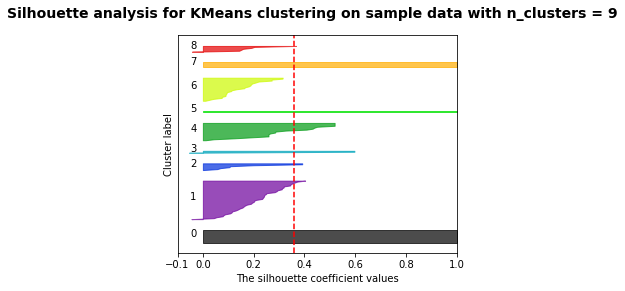

Number of items in cluster 0: 15
Number of items in cluster 1: 41
Number of items in cluster 2: 8
Number of items in cluster 3: 3
Number of items in cluster 4: 19
Number of items in cluster 5: 2
Number of items in cluster 6: 25
Number of items in cluster 7: 6
Number of items in cluster 8: 7


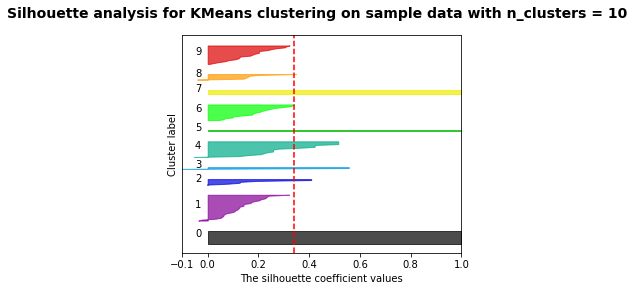

Number of items in cluster 0: 15
Number of items in cluster 1: 29
Number of items in cluster 2: 7
Number of items in cluster 3: 3
Number of items in cluster 4: 18
Number of items in cluster 5: 2
Number of items in cluster 6: 18
Number of items in cluster 7: 6
Number of items in cluster 8: 7
Number of items in cluster 9: 21


In [24]:
# Clusters with common categories in at least 30% of the neigborhoods
test_clusters(0.3)

#### p=0.4 tests 2 to 10 clusters with categories in at least 40% of the neigborhoods categories. This setting results in a better cluster distributions with 4 clusters with all clusters silhoutte avobe the mean.

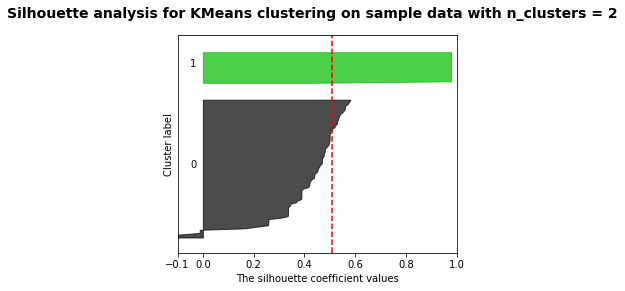

Number of items in cluster 0: 91
Number of items in cluster 1: 21


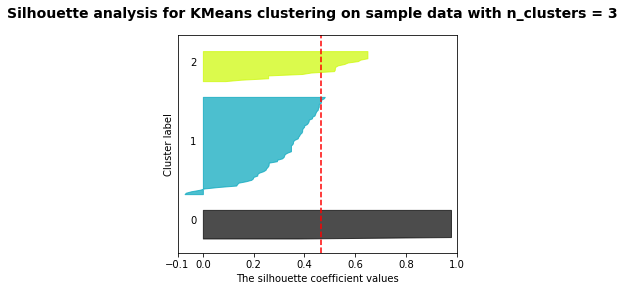

Number of items in cluster 0: 21
Number of items in cluster 1: 69
Number of items in cluster 2: 22


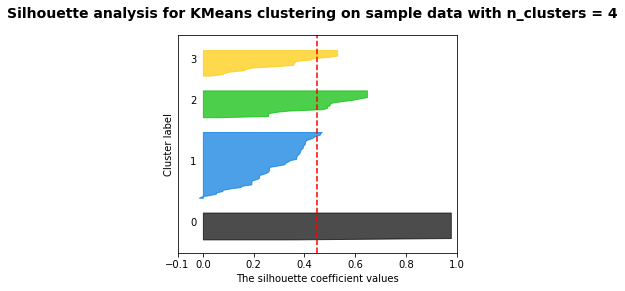

Number of items in cluster 0: 21
Number of items in cluster 1: 50
Number of items in cluster 2: 21
Number of items in cluster 3: 20


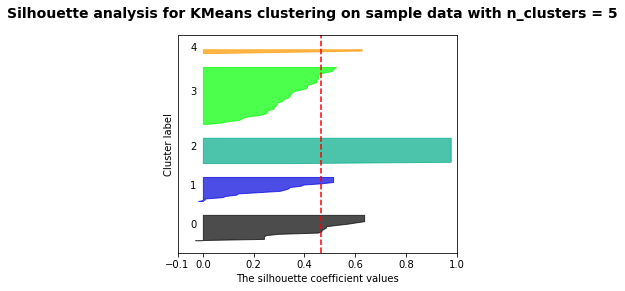

Number of items in cluster 0: 21
Number of items in cluster 1: 20
Number of items in cluster 2: 21
Number of items in cluster 3: 46
Number of items in cluster 4: 4


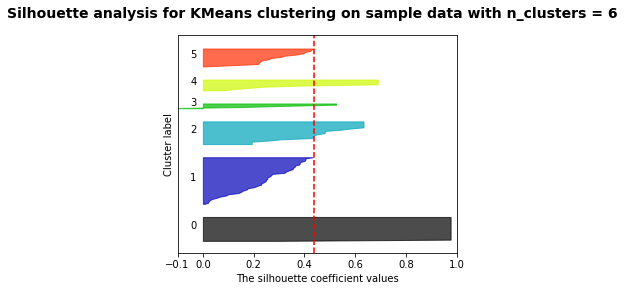

Number of items in cluster 0: 21
Number of items in cluster 1: 40
Number of items in cluster 2: 20
Number of items in cluster 3: 5
Number of items in cluster 4: 10
Number of items in cluster 5: 16


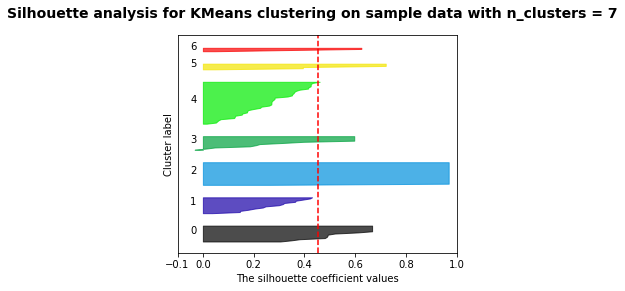

Number of items in cluster 0: 15
Number of items in cluster 1: 15
Number of items in cluster 2: 21
Number of items in cluster 3: 13
Number of items in cluster 4: 38
Number of items in cluster 5: 6
Number of items in cluster 6: 4


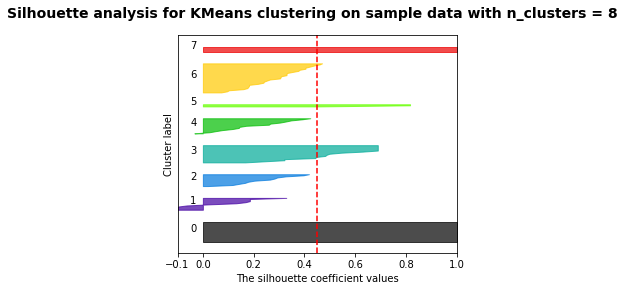

Number of items in cluster 0: 20
Number of items in cluster 1: 12
Number of items in cluster 2: 12
Number of items in cluster 3: 17
Number of items in cluster 4: 15
Number of items in cluster 5: 3
Number of items in cluster 6: 28
Number of items in cluster 7: 5


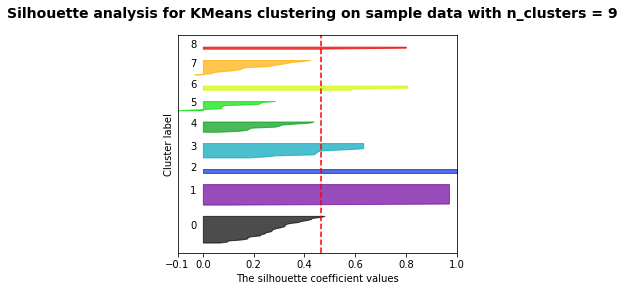

Number of items in cluster 0: 27
Number of items in cluster 1: 21
Number of items in cluster 2: 5
Number of items in cluster 3: 15
Number of items in cluster 4: 11
Number of items in cluster 5: 10
Number of items in cluster 6: 5
Number of items in cluster 7: 15
Number of items in cluster 8: 3


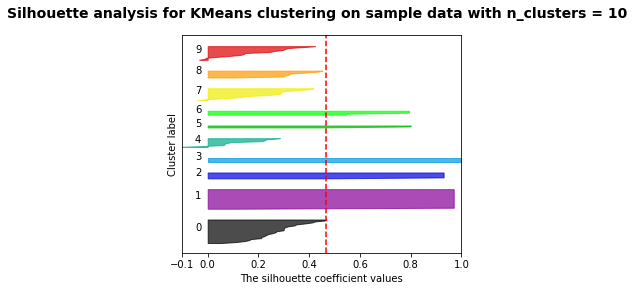

Number of items in cluster 0: 25
Number of items in cluster 1: 21
Number of items in cluster 2: 7
Number of items in cluster 3: 5
Number of items in cluster 4: 10
Number of items in cluster 5: 3
Number of items in cluster 6: 5
Number of items in cluster 7: 13
Number of items in cluster 8: 8
Number of items in cluster 9: 15


In [22]:
# Clusters with common categories in at least 40% of the neigborhoods
test_clusters(0.4)

#### 4 Clusters for categories in at least 40% of neighborhoods

In [26]:
filtered_venues = get_common_categories(0.4, venues)
cities_grouped = group_categories(filtered_venues)

cities_grouped_clustering = cities_grouped.drop(['City','Neighborhood'], 1)

clusterer = KMeans(n_clusters=4, random_state=10)
cluster_labels = clusterer.fit_predict(cities_grouped_clustering)

In [28]:
cities_grouped['Cluster'] = cluster_labels
cities_grouped.head()

,City,Neighborhood,Bakery,Café,Coffee Shop,Italian Restaurant,Park,Cluster
0,Amsterdam,Bijlmer-Centrum,0.000000,1.000000,0.000000,0.000000,0.000000,2
1,Amsterdam,Bijlmer-Oost,1.000000,0.000000,0.000000,0.000000,0.000000,1
2,Amsterdam,Bos en Lommer,0.285714,0.285714,0.142857,0.142857,0.142857,1
3,Amsterdam,Buitenveldert - Zuidas,0.166667,0.166667,0.166667,0.333333,0.166667,1
4,Amsterdam,Centrum-Oost,0.166667,0.166667,0.333333,0.166667,0.166667,1


## 4. Examine Clusters

#### Cluster 1

In [30]:
cities_grouped[cities_grouped['Cluster'] == 0]

,City,Neighborhood,Bakery,Bar,Café,Coffee Shop,Grocery Store,Italian Restaurant,Park,Pizza Place,Sandwich Place,Cluster
12,Amsterdam,Slotervaart,0.0,0.000000,0.000000,0.500000,0.500000,0.0,0.000000,0.000000,0.000000,0
15,London,Barking and Dagenham,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0
22,London,Ealing,0.0,0.000000,0.111111,0.111111,0.222222,0.0,0.333333,0.222222,0.000000,0
25,London,Hammersmith and Fulham,0.0,0.000000,0.166667,0.500000,0.333333,0.0,0.000000,0.000000,0.000000,0
29,London,Hillingdon,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.500000,0.500000,0.000000,0
30,London,Hounslow,0.0,0.000000,0.000000,0.000000,0.333333,0.0,0.000000,0.666667,0.000000,0
33,London,Kingston upon Thames,0.0,0.000000,0.142857,0.142857,0.428571,0.0,0.000000,0.142857,0.142857,0
49,Paris,Gobelins,0.0,0.000000,0.000000,0.000000,0.250000,0.0,0.250000,0.250000,0.250000,0
67,San Francisco,Diamond Heights,0.0,0.000000,0.000000,0.333333,0.333333,0.0,0.333333,0.000000,0.000000,0
84,San Francisco,Outer Sunset,0.0,0.166667,0.000000,0.166667,0.333333,0.0,0.000000,0.166667,0.166667,0


#### Cluster 2

In [31]:
cities_grouped[cities_grouped['Cluster'] == 1]

,City,Neighborhood,Bakery,Bar,Café,Coffee Shop,Grocery Store,Italian Restaurant,Park,Pizza Place,Sandwich Place,Cluster
8,Amsterdam,Gaasperdam - Driemond,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
9,Amsterdam,Geuzenveld - Slotermeer,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
16,London,Barnet,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
36,London,Merton,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
42,London,Wandsworth,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
62,San Francisco,Bayview,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
69,San Francisco,Excelsior,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
72,San Francisco,Golden Gate Park,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
76,San Francisco,Lakeshore,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
88,San Francisco,Presidio,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1


#### Cluster 3

In [32]:
cities_grouped[cities_grouped['Cluster'] == 2]

,City,Neighborhood,Bakery,Bar,Café,Coffee Shop,Grocery Store,Italian Restaurant,Park,Pizza Place,Sandwich Place,Cluster
1,Amsterdam,Bijlmer-Oost,0.666667,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2
2,Amsterdam,Bos en Lommer,0.214286,0.142857,0.142857,0.071429,0.000000,0.142857,0.142857,0.071429,0.071429,2
3,Amsterdam,Buitenveldert - Zuidas,0.200000,0.000000,0.200000,0.200000,0.000000,0.400000,0.000000,0.000000,0.000000,2
4,Amsterdam,Centrum-Oost,0.090909,0.272727,0.090909,0.181818,0.000000,0.090909,0.090909,0.181818,0.000000,2
5,Amsterdam,Centrum-West,0.043478,0.347826,0.347826,0.043478,0.000000,0.086957,0.000000,0.043478,0.086957,2
6,Amsterdam,De Baarsjes - Oud-West,0.040000,0.320000,0.160000,0.240000,0.040000,0.160000,0.000000,0.000000,0.040000,2
7,Amsterdam,De Pijp - Rivierenbuurt,0.083333,0.083333,0.250000,0.250000,0.083333,0.250000,0.000000,0.000000,0.000000,2
11,Amsterdam,Oud-Oost,0.190476,0.095238,0.190476,0.190476,0.047619,0.238095,0.047619,0.000000,0.000000,2
13,Amsterdam,Westerpark,0.100000,0.100000,0.200000,0.200000,0.100000,0.200000,0.100000,0.000000,0.000000,2
14,Amsterdam,Zuid,0.285714,0.285714,0.000000,0.142857,0.000000,0.285714,0.000000,0.000000,0.000000,2


#### Cluster 4

In [33]:
cities_grouped[cities_grouped['Cluster'] == 3]

,City,Neighborhood,Bakery,Bar,Café,Coffee Shop,Grocery Store,Italian Restaurant,Park,Pizza Place,Sandwich Place,Cluster
0,Amsterdam,Bijlmer-Centrum,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3
10,Amsterdam,Osdorp,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,3
20,London,Camden,0.000000,0.076923,0.461538,0.230769,0.000000,0.153846,0.076923,0.000000,0.000000,3
32,London,Kensington and Chelsea,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,3
35,London,Lewisham,0.000000,0.000000,0.400000,0.000000,0.400000,0.000000,0.200000,0.000000,0.000000,3
56,Paris,Palais-Bourbon,0.100000,0.000000,0.400000,0.100000,0.000000,0.300000,0.100000,0.000000,0.000000,3
83,San Francisco,Outer Richmond,0.100000,0.000000,0.500000,0.100000,0.000000,0.000000,0.000000,0.100000,0.200000,3
91,San Francisco,Seacliff,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,3
98,Sydney,Auburn,0.000000,0.000000,0.666667,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,3
102,Sydney,Canterbury,0.000000,0.000000,0.750000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,3
